[Reference: Novel indexes for diagnosing metabolic syndrome in apparently healthy Gujarati Asian Indians: a cross-sectional study](https://academic.oup.com/qjmed/article/109/11/717/2631720?login=false)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [2]:
LAP_params = {
                    'M': {'MetSN': [26.371, 17.52], 'MetSP': [57.77, 31.84]},
                    'F': {'MetSN': [25.62, 16.23], 'MetSP': [55.51, 30.94]}
            }

### Formulae

Males: (WC (cm) - 65) × (TG (mmol/l))

Females: (WC (cm) - 58) × (TG (mmol/l))

In [3]:
# wc(cm), TG(mg/dl)
def LAP(sex, wc, TG):
    if (sex == 'M'):
        return (wc-65) * (TG/88.57)
    elif (sex == 'F'):
        return (wc-58) * (TG/88.57)

In [4]:
# This is implementation of norm function of scipy. But the original norm function is efficient 
# and hence recommended to use
def z_score(x, params):
    return (x-params[0])/params[1]
def norm_percentile(x):
    return (1 + math.erf(x))/2

In [119]:
# patient_details = [sex, wc, TG]
def LAP_percentiles(LAP_params, patient_details, visualise=True):
    sex, wc, TG = patient_details
    lap = LAP(sex, wc, TG)
    print(f'LAP: {round(lap,2)}')
    percentiles = [norm.cdf(lap, LAP_params[sex][x][0], LAP_params[sex][x][1])*100 for x in ['MetSN', 'MetSP']]
    print(f'MetSN: {round(percentiles[0], 2)}th, MetSP: {round(percentiles[1], 2)}th')
    if(visualise):
        metsn_params = LAP_params[patient_details[0]]['MetSN']
        metsp_params = LAP_params[patient_details[0]]['MetSP']
        x1 = np.linspace(metsn_params[0]-3*metsn_params[1], metsn_params[0]+3*metsn_params[1], 200)
        x2 = np.linspace(metsp_params[0]-3*metsp_params[1], metsp_params[0]+3*metsp_params[1], 200)
        y1 = norm.pdf(x1, metsn_params[0], metsn_params[1])
        y2 = norm.pdf(x2, metsp_params[0], metsp_params[1])

        x = [lap]*3
        y = [0, norm.pdf(lap, metsn_params[0], metsn_params[1]), norm.pdf(lap, metsp_params[0], metsp_params[1])]

        plt.plot(x1, y1, color='blue', label='Negative')
        plt.plot(x2, y2, color='red', label='Positive')
        plt.plot(x, y, 'go--')
        plt.plot(lap,0, 'co', label=f'LAP = {round(lap,2)}')
        plt.ylim(0)
        plt.xlabel('LAP')
        plt.legend()
        plt.title('LAP MetS Distribution')
        plt.show()
    return percentiles

In [120]:
patient = ['M', 100, 150]

LAP: 59.28
MetSN: 96.98th, MetSP: 51.89th


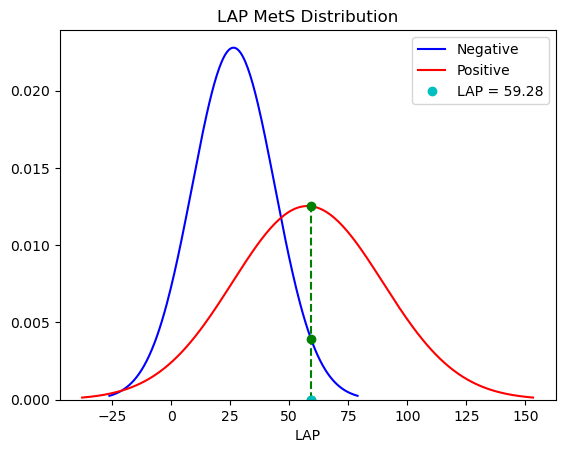

In [121]:
percentiles = LAP_percentiles(LAP_params, patient)